In [1]:
import rpy2
import rpy2.robjects.lib.ggplot2 as ggplot2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
base = importr('base')

# the base of rpy2 plotting is matplotlib, thus we need to declare
# it inline in order to see the plots in the notebook
%matplotlib inline

# we need to activate the automatic conversion for pandas
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# load the needed extension for the %%R cell magic
%load_ext rpy2.ipython

import numpy as np
import pandas as pd

%config IPCompleter.greedy=True

import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 200

In [3]:
import ray
ray.init()

RuntimeError: Maybe you called ray.init twice by accident? This error can be suppressed by passing in 'ignore_reinit_error=True' or by calling 'ray.shutdown()' prior to 'ray.init()'.

In [8]:
rootdir = "/home/akshayn/burrito"
outdirs = ["kv-825ef8d"]
#num_shards = [2, 4, 6, 8]
num_shards = [4,]
#ops = [1000, 5000, 10000, 20000, 40000, 60000, 80000, 100000, 160000, 200000, 240000, 320000]
ops = [10000, 20000, 40000, 60000, 80000, 100000, 120000]
clients = ['10.1.1.5', '10.1.1.6', '10.1.1.7', '10.1.1.8', '10.1.1.9']
#shard_types = ['client', 'server', 'basicclient']
shard_types = ['client']
#client_concurrency = [4, 8]
client_concurrency = [4]
client_batching = [0]
server_batching = ["none"]
poisson = [True]
fragmentation = [False, True]

In [19]:
# note: this aggregates requestclients together

@ray.remote
def read_exp(outdir, ns, st, o, p, cb, sb, fr, c):
    exp_df = None
    for cl in clients:
        fn = f"{rootdir}/{outdir}/{ns}-{st}shard-{o}-poisson={p}-client_batch={cb}-server_batch={sb}-stackfrag={fr}-wrkloadbunf1-{c}-0-client0-{cl}.data"
        try:
            df_file = pd.read_csv(fn, sep=" ")
            df_file["ShardType"] = st
            df_file['NumShards'] = ns
            df_file["Ops"] = o
            df_file = df_file[(df_file.NumOps > 200e3) & (df_file.NumShards > 1)]

            if exp_df is None:
                exp_df = df_file
            else:
                exp_df = exp_df.append(df_file)
        except Exception as e:
            print('error on', fn, e)
            continue
    if exp_df is None:
        print('df was None', ns, st, o, p, cb, sb, fr, c, clients)
        return pd.DataFrame()
    # now calculate this experiment's stats.
    exp_stats = exp_df.groupby(["ShardType", "NumShards", "Ops"]).quantile([0.05, 0.25, 0.5, 0.75, 0.95])
    exp_stats = exp_stats.unstack()
    exp_stats.columns = [f"{s}_{t}" for s,t in exp_stats.columns.values]
    exp_stats.columns.to_flat_index()
    exp_stats["Commit"] = outdir
    exp_stats["Concurrency"] = c
    exp_stats["ClientBatching"] = cb
    exp_stats["ServerBatching"] = sb
    exp_stats["Poisson"] = p
    exp_stats["Fragmentation"] = fr
    return exp_stats

exps = []
for outdir in outdirs:
    for fr in fragmentation:
        for ns in num_shards:
            for st in shard_types:
                for o in ops:
                    o = int(o)
                    for p in poisson:
                        for cb in client_batching:
                            for sb in server_batching:
                                for c in client_concurrency:
                                    exps.append(read_exp.remote(outdir, ns, st, o, p, cb, sb, fr, c))

exp_dfs = ray.get(exps)
df = None
for exp_df in exp_dfs:
    if df is None:
        df = exp_df
    else:
        df = df.append(exp_df)

df = df.reset_index()
df

,ShardType,NumShards,Ops,Interarrival_us_0.05,Interarrival_us_0.25,Interarrival_us_0.5,Interarrival_us_0.75,Interarrival_us_0.95,NumOps_0.05,NumOps_0.25,...,Latency_us_0.25,Latency_us_0.5,Latency_us_0.75,Latency_us_0.95,Commit,Concurrency,ClientBatching,ServerBatching,Poisson,Fragmentation
0,client,4,10000,2000.0,2000.0,2000.0,2000.0,2000.0,276394.0,276395.0,...,47.0,51.0,55.0,63.0,kv-825ef8d,4,0,none,True,False
1,client,4,20000,1000.0,1000.0,1000.0,1000.0,1000.0,276395.0,276401.0,...,47.0,52.0,56.0,63.0,kv-825ef8d,4,0,none,True,False
2,client,4,40000,500.0,500.0,500.0,500.0,500.0,276337.0,276408.0,...,45.0,50.0,54.0,62.0,kv-825ef8d,4,0,none,True,False
3,client,4,60000,333.0,333.0,333.0,333.0,333.0,276397.0,276402.0,...,56.0,63.0,72.0,101.0,kv-825ef8d,4,0,none,True,False
4,client,4,80000,250.0,250.0,250.0,250.0,250.0,276393.0,276412.0,...,52.0,58.0,67.0,120.0,kv-825ef8d,4,0,none,True,False
5,client,4,100000,200.0,200.0,200.0,200.0,200.0,276394.0,276403.0,...,50.0,57.0,69.0,188.0,kv-825ef8d,4,0,none,True,False
6,client,4,120000,166.0,166.0,166.0,166.0,166.0,276109.0,276381.0,...,49.0,57.0,74.0,234.0,kv-825ef8d,4,0,none,True,False
7,client,4,10000,2000.0,2000.0,2000.0,2000.0,2000.0,276394.0,276396.0,...,66.0,73.0,83.0,102.0,kv-825ef8d,4,0,none,True,True
8,client,4,20000,1000.0,1000.0,1000.0,1000.0,1000.0,276289.0,276342.0,...,66.0,74.0,84.0,102.0,kv-825ef8d,4,0,none,True,True
9,client,4,40000,500.0,500.0,500.0,500.0,500.0,276273.0,276383.0,...,66.0,74.0,84.0,104.0,kv-825ef8d,4,0,none,True,True


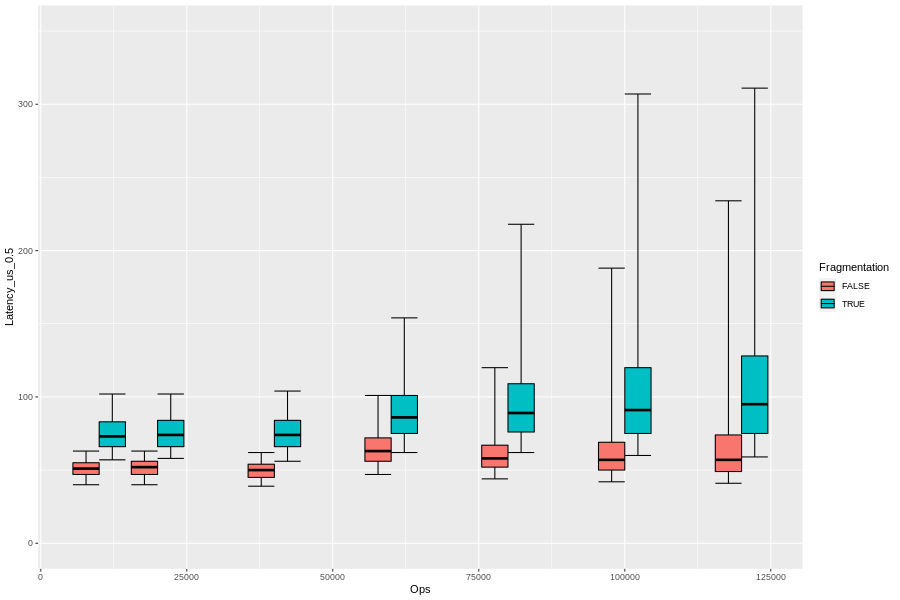

In [23]:
%%R -i df -w 900 -h 600

library(ggplot2)

#geom_boxplot(aes(group=interaction(ShardType,Ops)), position="dodge") + 
#ggplot(pdf, aes(x=Ops, y=Latency_us, 
#  fill=ShardType, group=interaction(ShardType,Ops))) + 
#    stat_summary(fun.data = f, geom="boxplot", position="dodge") + 
#    facet_grid(NumShards~Concurrency) +
#    coord_cartesian(ylim=c(0, 10000))

ggplot(df, aes(x=Ops, fill=Fragmentation, group=interaction(Fragmentation, ShardType,Ops))) +
  geom_errorbar(aes(ymin=Latency_us_0.05, ymax = Latency_us_0.95), position="dodge") +
  geom_crossbar(aes(ymin=Latency_us_0.25, y=Latency_us_0.5, ymax = Latency_us_0.75), position="dodge") +
  coord_cartesian(ylim=c(0, 350))
    

## Actual Batch Sizes

In [ ]:
import re
read_sizes = re.compile(r"client_id=([0-9]+).*p5=([0-9]+) p25=([0-9]+) p50=([0-9]+) p75=([0-9]+) p95=([0-9]+) cnt=([0-9]+)")

def batch_sizes(fn):
    x = []
    with open(fn, 'r') as f:
        for line in f:
            if "send_batch_size" not in line:
                continue
            m = read_sizes.search(line)
            x.append({
                'client_id': m.group(1), 
                'p5': int(m.group(2)),
                'p25': int(m.group(3)),
                'p50': int(m.group(4)),
                'p75': int(m.group(5)),
                'p95': int(m.group(6)),
                'cnt': int(m.group(7))
            })
    return x
        

batch_size_data = None
for outdir in outdirs:
    for ns in num_shards:
        for o in ops:
            o = int(o)
            for st in shard_types:
                for cl in clients:
                    for c in client_concurrency:
                        for b in batching:
                            try:
                                fn = f"{rootdir}/{outdir}/{ns}-{st}shard-{o}-batch={b}-wrkloadbunf1-{c}-0-client0-{cl}.out"
                                data = batch_sizes(fn)
                                df_file = pd.DataFrame.from_records(data)
                                df_file["Ops"] = o
                                df_file["Client"] = cl
                                df_file["Concurrency"] = c
                                df_file["Commit"] = outdir
                                df_file["Batching"] = b
                                if batch_size_data is None:
                                    batch_size_data = df_file
                                else:
                                    batch_size_data = batch_size_data.append(df_file)
                            except:
                                print(fn)

batch_size_data
#dfq = df.groupby(["Commit", "ShardType", "NumShards", "Wrkload", "Concurrency", "Batching", "Ops"]).quantile([0.05, 0.25, 0.5, 0.75, 0.95])
#dfq.head()

In [ ]:
%%R -i batch_size_data -w 900 -h 600

ggplot(batch_size_data, aes(x=Ops, fill=Client, group=interaction(Client,Ops))) +
  geom_errorbar(aes(ymin=p5, ymax = p95), position="dodge") +
  geom_crossbar(aes(ymin=p25, y=p50, ymax = p75), position="dodge") +
  facet_grid(Commit~Batching)
#  coord_cartesian(ylim=c(0, 500))

#### With a dedicated load balancer

In [ ]:
lboutdirs = ["kvlb-1883ee8", "kvlb-79b6c33"]
# num_shards = 2 machines, fixed
lbops = [5000, 10000, 20000, 40000, 60000, 80000, 100000]
lbshard_types = ['client', 'server']
lbclients = ['10.1.1.7', '10.1.1.8', '10.1.1.9']
lbclient_concurrency = [4, 8]

In [ ]:
lbdf = None
for lboutdir in lboutdirs:
    for o in lbops:
        for st in lbshard_types:
            for cl in lbclients:
                for c in lbclient_concurrency:
                    fn = f"{lboutdir}/{st}shard-{o}-wrkloadbunf1-{c}-client0-{cl}.data"
                    try:
                        df_file = md.read_csv(fn, sep=" ")
                        df_file = df_file[(df_file.NumOps > 200000)]
                        df_file["Commit"] = lboutdir
                        df_file["Concurrency"] = c
                        if lbdf is None:
                            lbdf = df_file
                        else:
                            lbdf = lbdf.append(df_file)
                    except:
                        continue

lbdfq = lbdf.groupby(["Commit", "ShardType", "NumShards", "Ops", "Concurrency"]).quantile([0.05, 0.25, 0.5, 0.75, 0.95])
lbdfq

In [ ]:
lbdfqu = lbdfq.unstack()
lbdfqu.columns = [f"{s}_{t}" for s,t in lbdfqu.columns.values]
lbdfqu.columns.to_flat_index()
lbdfqu.to_csv('/tmp/kvlb-tmp.csv')
lbdfqu

In [ ]:
plbdf = pd.read_csv('/tmp/kvlb-tmp.csv')

In [ ]:
%%R -i plbdf -w 900 -h 600

#f <- function(x) {
#  r <- quantile(x, probs = c(0.05, 0.25, 0.5, 0.75, 0.95))
#  names(r) <- c("ymin", "lower", "middle", "upper", "ymax")
#  r
#}

ggplot(plbdf, aes(x=Ops, fill=ShardType, group=interaction(ShardType,Ops))) +
  geom_errorbar(aes(ymin=Latency_us_0.05, ymax = Latency_us_0.95), position="dodge") +
  geom_crossbar(aes(ymin=Latency_us_0.25, y=Latency_us_0.5, ymax = Latency_us_0.75), position="dodge") +
  facet_grid(Commit~Concurrency) +
  coord_cartesian(ylim=c(0, 1000))